In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

## Baseline

In [3]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_base_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_base_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057


# Kparallel

In [5]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [6]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=kparallel

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_kparallel_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_kparallel_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kparallel.o -o stencil2d-kparallel.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


cp stencil2d-kparallel.x stencil2d.x


oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

## Static

In [7]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [8]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=static

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_static_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-static.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_static_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-static.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-static.o -o stencil2d-static.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-static.x' (lite-samples) ...OK


cp stencil2d-static.x stencil2d.x


srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CH

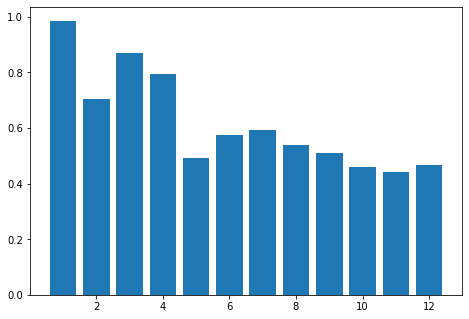

In [9]:
# Single-Plot (bar plot)
exec(open("out_static_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

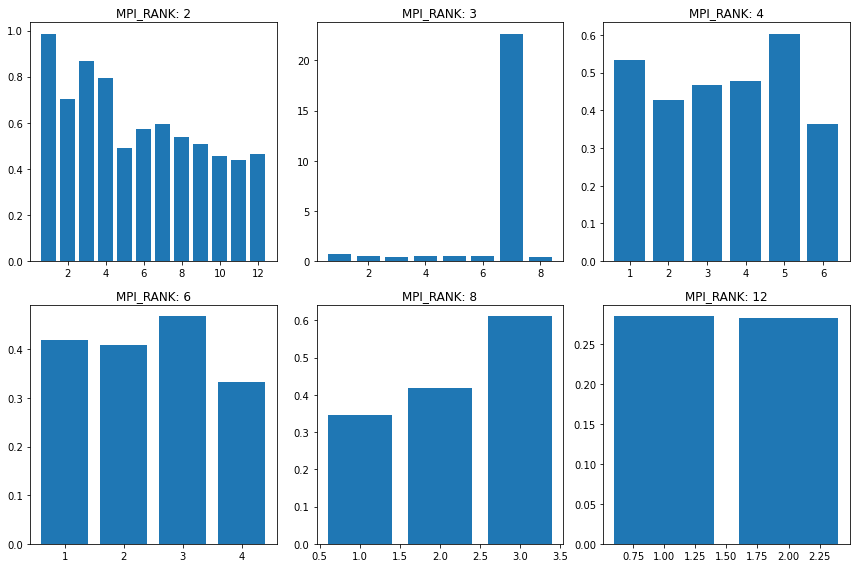

In [10]:
# Multi-Plot (bar plot)

mpi_files = ["out_static_mpi2.txt", "out_static_mpi3.txt", "out_static_mpi4.txt", "out_static_mpi6.txt", "out_static_mpi8.txt", "out_static_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

[0.6184922250000001, 3.2858050125000005, 0.47832919999999995, 0.40744715, 0.45844060000000003, 0.2833074]


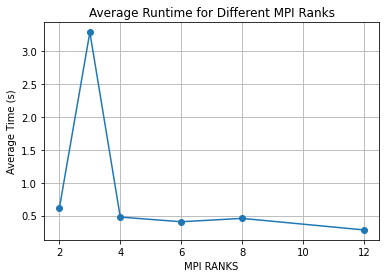

In [11]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_static_mpi2.txt", "out_static_mpi3.txt", "out_static_mpi4.txt", "out_static_mpi6.txt", "out_static_mpi8.txt", "out_static_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))

print(time_mpi)

# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

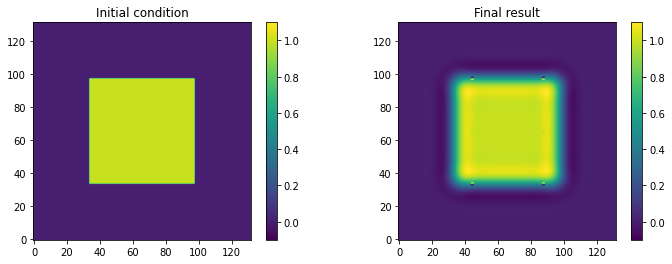

In [12]:
validate_results()

## Dynamic

In [13]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [14]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=dynamic

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_dynamic_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-dynamic.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_dynamic_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-dynamic.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-dynamic.o -o stencil2d-dynamic.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-dynamic.x' (lite-samples) ...OK


cp stencil2d-dynamic.x stencil2d.x


srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
srun: Job 48015057 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48015057
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be 

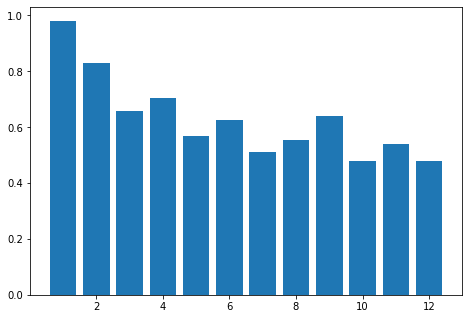

In [15]:
# Single-Plot (bar plot)
exec(open("out_dynamic_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

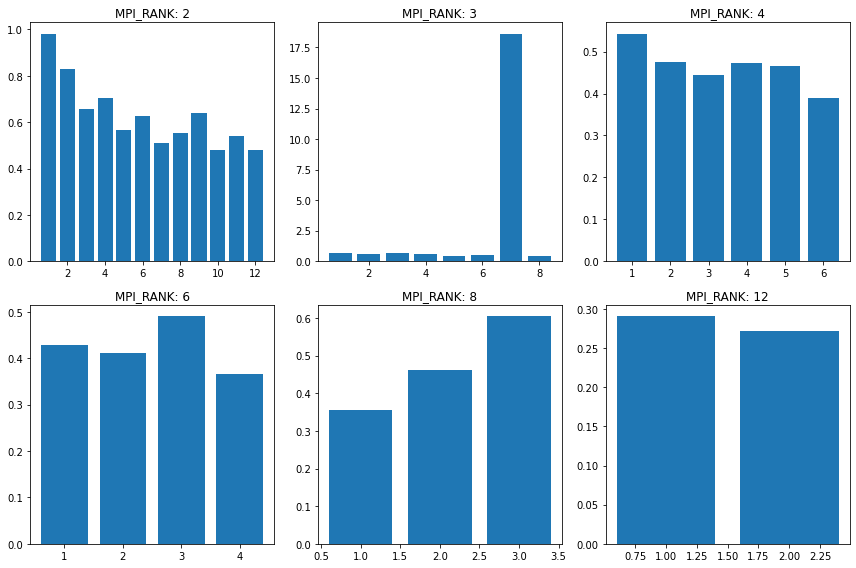

In [16]:
# Multi-Plot (bar plot)

mpi_files = ["out_dynamic_mpi2.txt", "out_dynamic_mpi3.txt", "out_dynamic_mpi4.txt", "out_dynamic_mpi6.txt", "out_dynamic_mpi8.txt", "out_dynamic_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

[0.6308922333333332, 2.8137635375, 0.4652112, 0.424072675, 0.4742378333333333, 0.2813215]


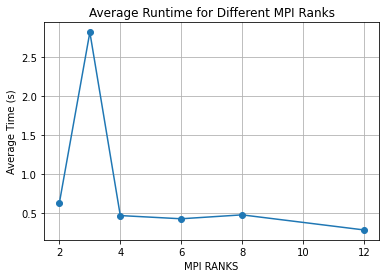

In [17]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_dynamic_mpi2.txt", "out_dynamic_mpi3.txt", "out_dynamic_mpi4.txt", "out_dynamic_mpi6.txt", "out_dynamic_mpi8.txt", "out_dynamic_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))

print(time_mpi)    

# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

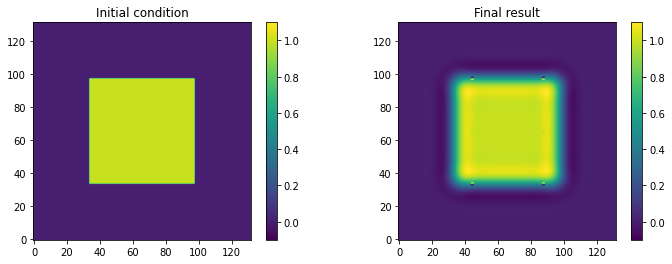

In [18]:
validate_results()

## Guided

In [19]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [20]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=guided

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_guided_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-guided.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_guided_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-guided.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-guided.o -o stencil2d-guided.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-guided.x' (lite-samples) ...OK


cp stencil2d-guided.x stencil2d.x


oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

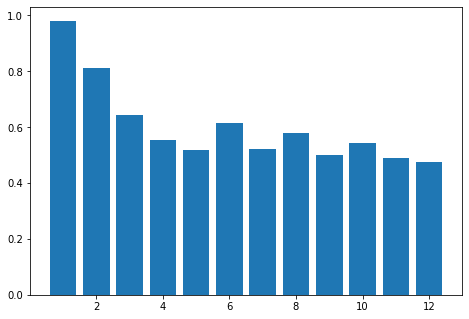

In [21]:
# Single-Plot (bar plot)
exec(open("out_guided_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

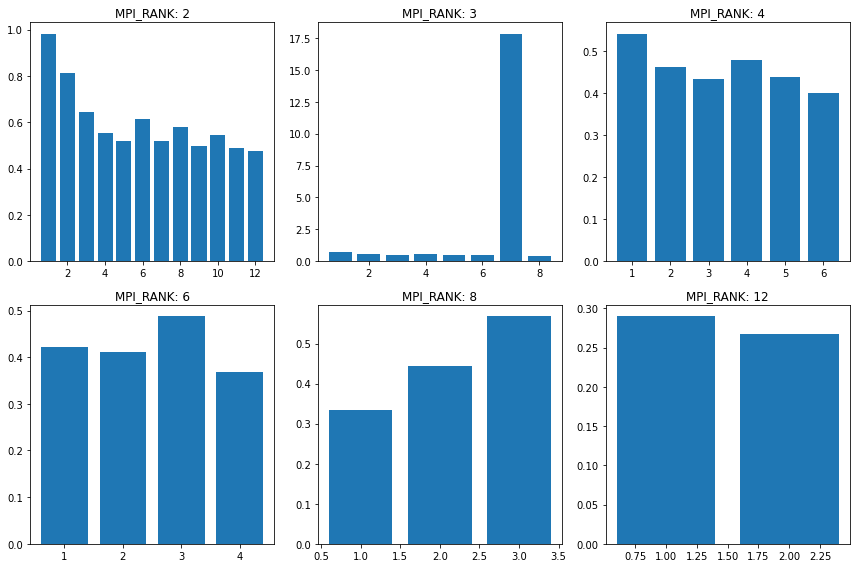

In [22]:
# Multi-Plot (bar plot)

mpi_files = ["out_guided_mpi2.txt", "out_guided_mpi3.txt", "out_guided_mpi4.txt", "out_guided_mpi6.txt", "out_guided_mpi8.txt", "out_guided_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

[0.6028153, 2.6982022000000003, 0.4588367, 0.4217011, 0.4491417666666666, 0.2788538]


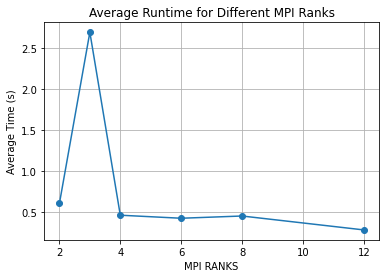

In [23]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_guided_mpi2.txt", "out_guided_mpi3.txt", "out_guided_mpi4.txt", "out_guided_mpi6.txt", "out_guided_mpi8.txt", "out_guided_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))
    
print(time_mpi)
    
# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

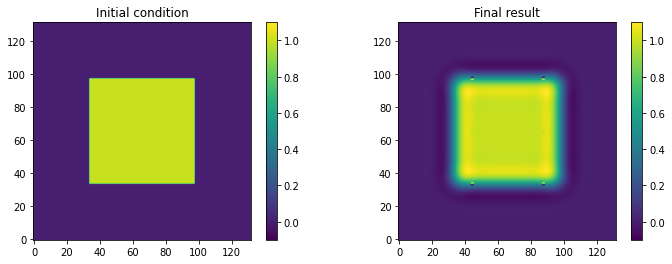

In [24]:
validate_results()

## Final Plot
In this section, we will combine our results into two plot.

[0.9482584000000001, 0.67761155, 0.52428805, 0.4054599, 0.3239491, 0.2711044]
[0.50781345, 0.47852285, 0.40813815, 0.41197934999999997, 0.3747838, 0.27935600000000005]
[0.55622185, 0.53625565, 0.47158330000000004, 0.41429249999999995, 0.4179859, 0.2833074]
[0.59665255, 0.5766201, 0.46943455, 0.42031605, 0.4626595, 0.2813215]
[0.54840365, 0.53641855, 0.44983455, 0.41603305, 0.4452305, 0.2788538]


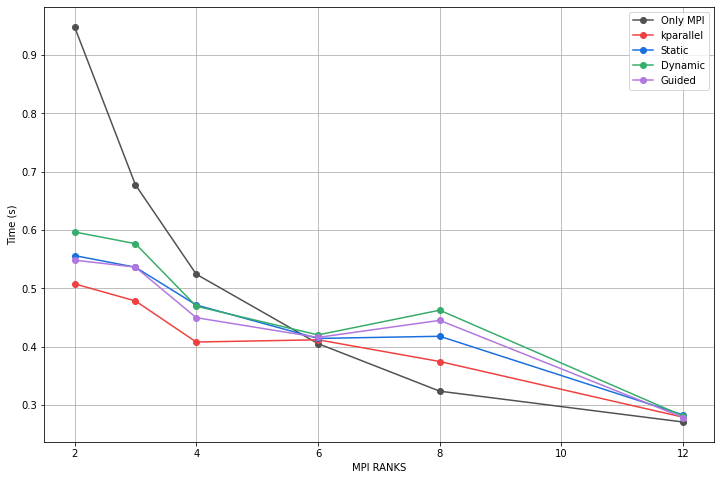

In [25]:
# line-Plot (runtime for different ranks, average of different thread results, different parallel)

mpi_files_list = [
    ["out_base_mpi2.txt", "out_base_mpi3.txt", "out_base_mpi4.txt", "out_base_mpi6.txt", "out_base_mpi8.txt", "out_base_mpi12.txt"],
    ["out_kparallel_mpi2.txt", "out_kparallel_mpi3.txt", "out_kparallel_mpi4.txt", "out_kparallel_mpi6.txt", "out_kparallel_mpi8.txt", "out_kparallel_mpi12.txt"],
    ["out_static_mpi2.txt", "out_static_mpi3.txt", "out_static_mpi4.txt", "out_static_mpi6.txt", "out_static_mpi8.txt", "out_static_mpi12.txt"],
    ["out_dynamic_mpi2.txt", "out_dynamic_mpi3.txt", "out_dynamic_mpi4.txt", "out_dynamic_mpi6.txt", "out_dynamic_mpi8.txt", "out_dynamic_mpi12.txt"], 
    ["out_guided_mpi2.txt", "out_guided_mpi3.txt", "out_guided_mpi4.txt", "out_guided_mpi6.txt", "out_guided_mpi8.txt", "out_guided_mpi12.txt"]  
]

num_mpi= [2, 3, 4, 6, 8, 12]
colors = [(81/255, 81/255, 81/255), (241/255, 64/255, 64/255), (26/255, 111/255, 223/255), (55/255, 173/255, 107/255), (177/255, 119/255, 222/255)]  # Color for each set of bars
fig = plt.figure(figsize=(12, 8))

# For each list of mpi_files
for file_idx, mpi_files in enumerate(mpi_files_list):
    time_mpi = []

    for idx, mpi_file in enumerate(mpi_files):
        exec(open(mpi_file, "r").read())

        labels = []
        times = []
        for i in range(len(out)):
            if i == 0:
                continue
            labels.append(i)
            times.append(out[i][:, 5].item())
        time_mpi.append(np.median(times))
    
    print(time_mpi)
    
    # Plot   
    plt.plot(num_mpi, time_mpi, marker='o', linestyle='-', color=colors[file_idx])

plt.xlabel('MPI RANKS')
plt.ylabel('Time (s)')
#plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.legend(["Only MPI", "kparallel", "Static", "Dynamic", "Guided"])  # Add legend based on your list of mpi_files
plt.savefig("Schedule_line.svg", format='svg')
plt.show()


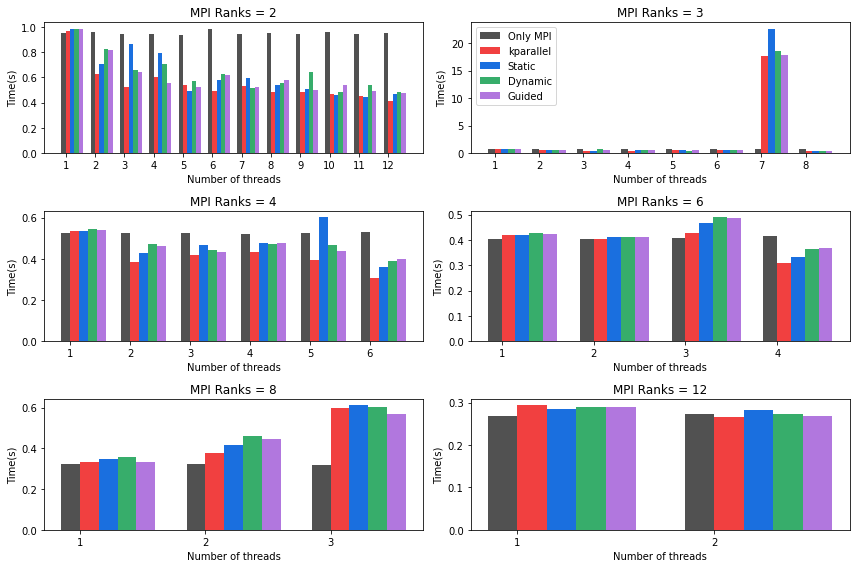

In [26]:
from matplotlib.ticker import MaxNLocator

mpi_files_list = [
    ["out_base_mpi2.txt", "out_base_mpi3.txt", "out_base_mpi4.txt", "out_base_mpi6.txt", "out_base_mpi8.txt", "out_base_mpi12.txt"],
    ["out_kparallel_mpi2.txt", "out_kparallel_mpi3.txt", "out_kparallel_mpi4.txt", "out_kparallel_mpi6.txt", "out_kparallel_mpi8.txt", "out_kparallel_mpi12.txt"],
    ["out_static_mpi2.txt", "out_static_mpi3.txt", "out_static_mpi4.txt", "out_static_mpi6.txt", "out_static_mpi8.txt", "out_static_mpi12.txt"],
    ["out_dynamic_mpi2.txt", "out_dynamic_mpi3.txt", "out_dynamic_mpi4.txt", "out_dynamic_mpi6.txt", "out_dynamic_mpi8.txt", "out_dynamic_mpi12.txt"], 
    ["out_guided_mpi2.txt", "out_guided_mpi3.txt", "out_guided_mpi4.txt", "out_guided_mpi6.txt", "out_guided_mpi8.txt", "out_guided_mpi12.txt"]  
]

num_mpi = [2, 3, 4, 6, 8, 12]
num_rows = 3
num_cols = 2
width = 0.15  # Adjust the width of the bar
colors = [(81/255, 81/255, 81/255), (241/255, 64/255, 64/255), (26/255, 111/255, 223/255), (55/255, 173/255, 107/255), (177/255, 119/255, 222/255)]  # Color for each set of bars

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for file_idx, mpi_files in enumerate(mpi_files_list):
    for idx, mpi_file in enumerate(mpi_files):
        exec(open(mpi_file, "r").read())

        labels = []
        times = []
        for i in range(len(out)):
            if i == 0:
                continue
            labels.append(i)
            times.append(out[i][:, 5].item())

        x = np.arange(len(labels)) 

        row_idx = idx // num_cols
        col_idx = idx % num_cols

        # Adjust the position of the bar
        axes[row_idx, col_idx].bar(x - width/2 + file_idx*width, times, width=width, label="List " + str(file_idx+1), color=colors[file_idx])
        axes[row_idx, col_idx].set_xlabel('Number of threads')  # Set x-axis label
        axes[row_idx, col_idx].set_ylabel('Time(s)')  # Set y-axis label
        axes[row_idx, col_idx].set_xticks(x)  # Set x-ticks
        axes[row_idx, col_idx].set_xticklabels(labels)  # Set x-tick labels
        
        # Set title for each subplots
        axes[row_idx, col_idx].set_title('MPI Ranks = ' + str(num_mpi[idx]))

# Only add legend to the second plot
axes[0, 1].legend(["Only MPI", "kparallel", "Static", "Dynamic", "Guided"])

plt.tight_layout()
plt.savefig("Schedule_bar.svg", format='svg')
plt.show()
